# Basic Data Cleaning Techniques

Data cleaning is one of the most important steps in any data science project. This notebook covers essential techniques for preparing your data for analysis and modeling.

## Import Required Libraries

Let's start by importing essential libraries for data cleaning:

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)

# For reproducibility
np.random.seed(42)

## Loading Sample Data

For this demonstration, we'll create sample datasets with common data quality issues like missing values, duplicates, and inconsistent formatting. We'll also load a built-in dataset.

In [2]:
# Create a sample dataset with common data quality issues
def create_sample_data(rows=100):
    """Create a sample dataframe with various data quality issues"""
    
    # Base data with some random values
    data = {
        'customer_id': np.arange(1, rows+1),
        'age': np.random.randint(18, 90, size=rows),
        'income': np.random.normal(50000, 15000, size=rows).round(2),
        'date_joined': pd.date_range(start='2020-01-01', periods=rows),
        'last_purchase': pd.date_range(start='2020-02-01', periods=rows),
        'category': np.random.choice(['A', 'B', 'C', 'D'], size=rows),
        'email': [f'customer{i}@example.com' for i in range(1, rows+1)],
        'address': [f'{i} Main Street' for i in range(1, rows+1)]
    }
    
    df = pd.DataFrame(data)
    
    # Introduce missing values (approximately 10%)
    for col in df.columns:
        if col != 'customer_id':  # Keep IDs intact
            mask = np.random.random(size=rows) < 0.1
            df.loc[mask, col] = np.nan
    
    # Add duplicate rows (approximately 5%)
    dupes = df.sample(int(rows * 0.05)).copy()
    df = pd.concat([df, dupes], ignore_index=True)
    
    # Add some outliers to numeric columns
    outlier_idx = np.random.choice(df.index, size=3)
    df.loc[outlier_idx, 'age'] = [120, 125, 130]
    
    outlier_idx = np.random.choice(df.index, size=3)
    df.loc[outlier_idx, 'income'] = [200000, 250000, 300000]
    
    # Add inconsistent formatting to categorical columns
    mask = np.random.random(size=len(df)) < 0.1
    df.loc[mask, 'category'] = df.loc[mask, 'category'].str.lower()
    
    # Add extra whitespace to some text fields
    mask = np.random.random(size=len(df)) < 0.1
    df.loc[mask, 'email'] = '  ' + df.loc[mask, 'email'] + '  '
    
    return df

# Generate messy data
messy_data = create_sample_data(100)
messy_data.head()

,customer_id,age,income,date_joined,last_purchase,category,email,address
0,1,69.0,62521.93,2020-01-01,2020-02-01,b,customer1@example.com,1 Main Street
1,2,32.0,54448.42,2020-01-02,2020-02-02,C,customer2@example.com,2 Main Street
2,3,89.0,34432.55,2020-01-03,NaT,D,customer3@example.com,3 Main Street
3,4,78.0,48862.94,2020-01-04,2020-02-04,A,NaN,4 Main Street
4,5,38.0,64594.45,2020-01-05,2020-02-05,a,customer5@example.com,5 Main Street


In [3]:
# Let's also load a real-world dataset for comparison
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


## Identifying Missing Values

Missing values are common in real-world datasets. Let's explore methods to detect them using pandas functions and visualize their patterns.

In [4]:
# Basic check for missing values in our messy data
print("Missing values per column:")
print(messy_data.isnull().sum())

print("\nPercentage of missing values:")
print((messy_data.isnull().sum() / len(messy_data) * 100).round(2))

# Check for missing values in the titanic dataset
print("\nMissing values in the Titanic dataset:")
print(titanic.isnull().sum())

Missing values per column:
customer_id       0
age              15
income           16
date_joined       9
last_purchase    11
category          4
email             9
address          12
dtype: int64

Percentage of missing values:
customer_id       0.00
age              14.29
income           15.24
date_joined       8.57
last_purchase    10.48
category          3.81
email             8.57
address          11.43
dtype: float64

Missing values in the Titanic dataset:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


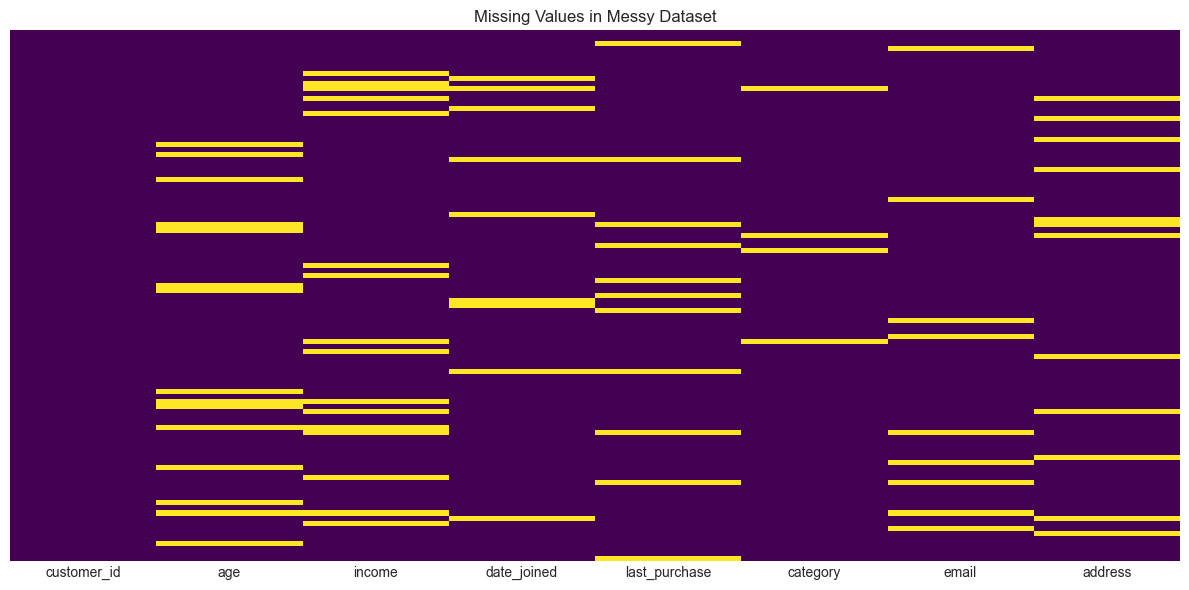

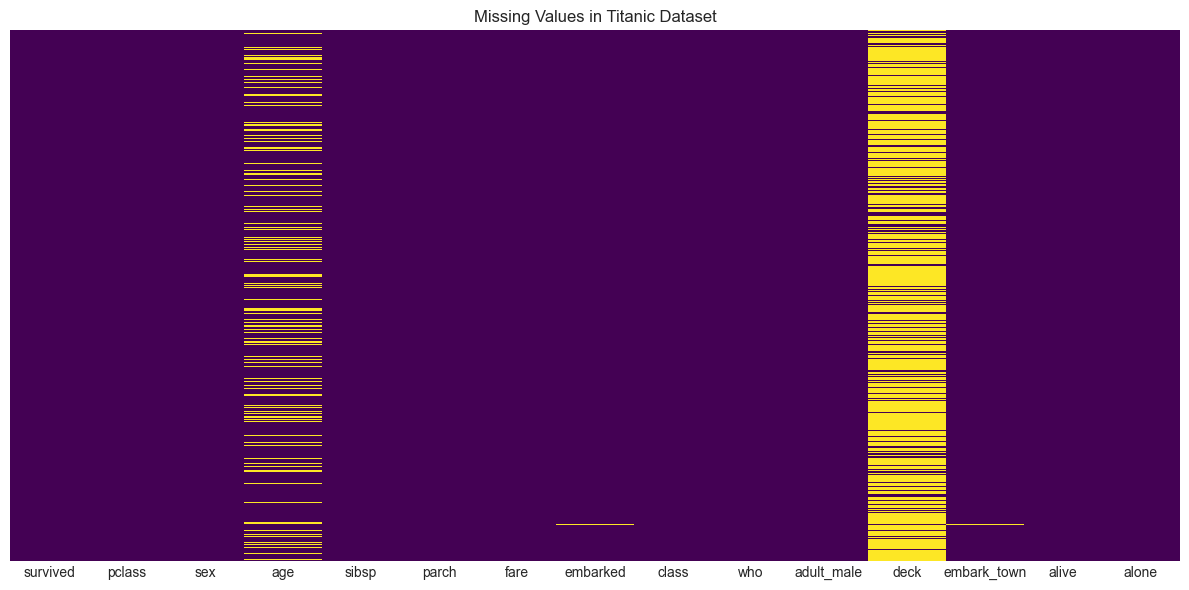

In [5]:
# Visualize missing values using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(messy_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values in Messy Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(titanic.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values in Titanic Dataset')
plt.tight_layout()
plt.show()

The heatmap provides a visual representation of missing values in the dataset. Yellow areas indicate missing values, while purple areas indicate existing values.

We can also use the `missingno` library for enhanced visualization of missing values:

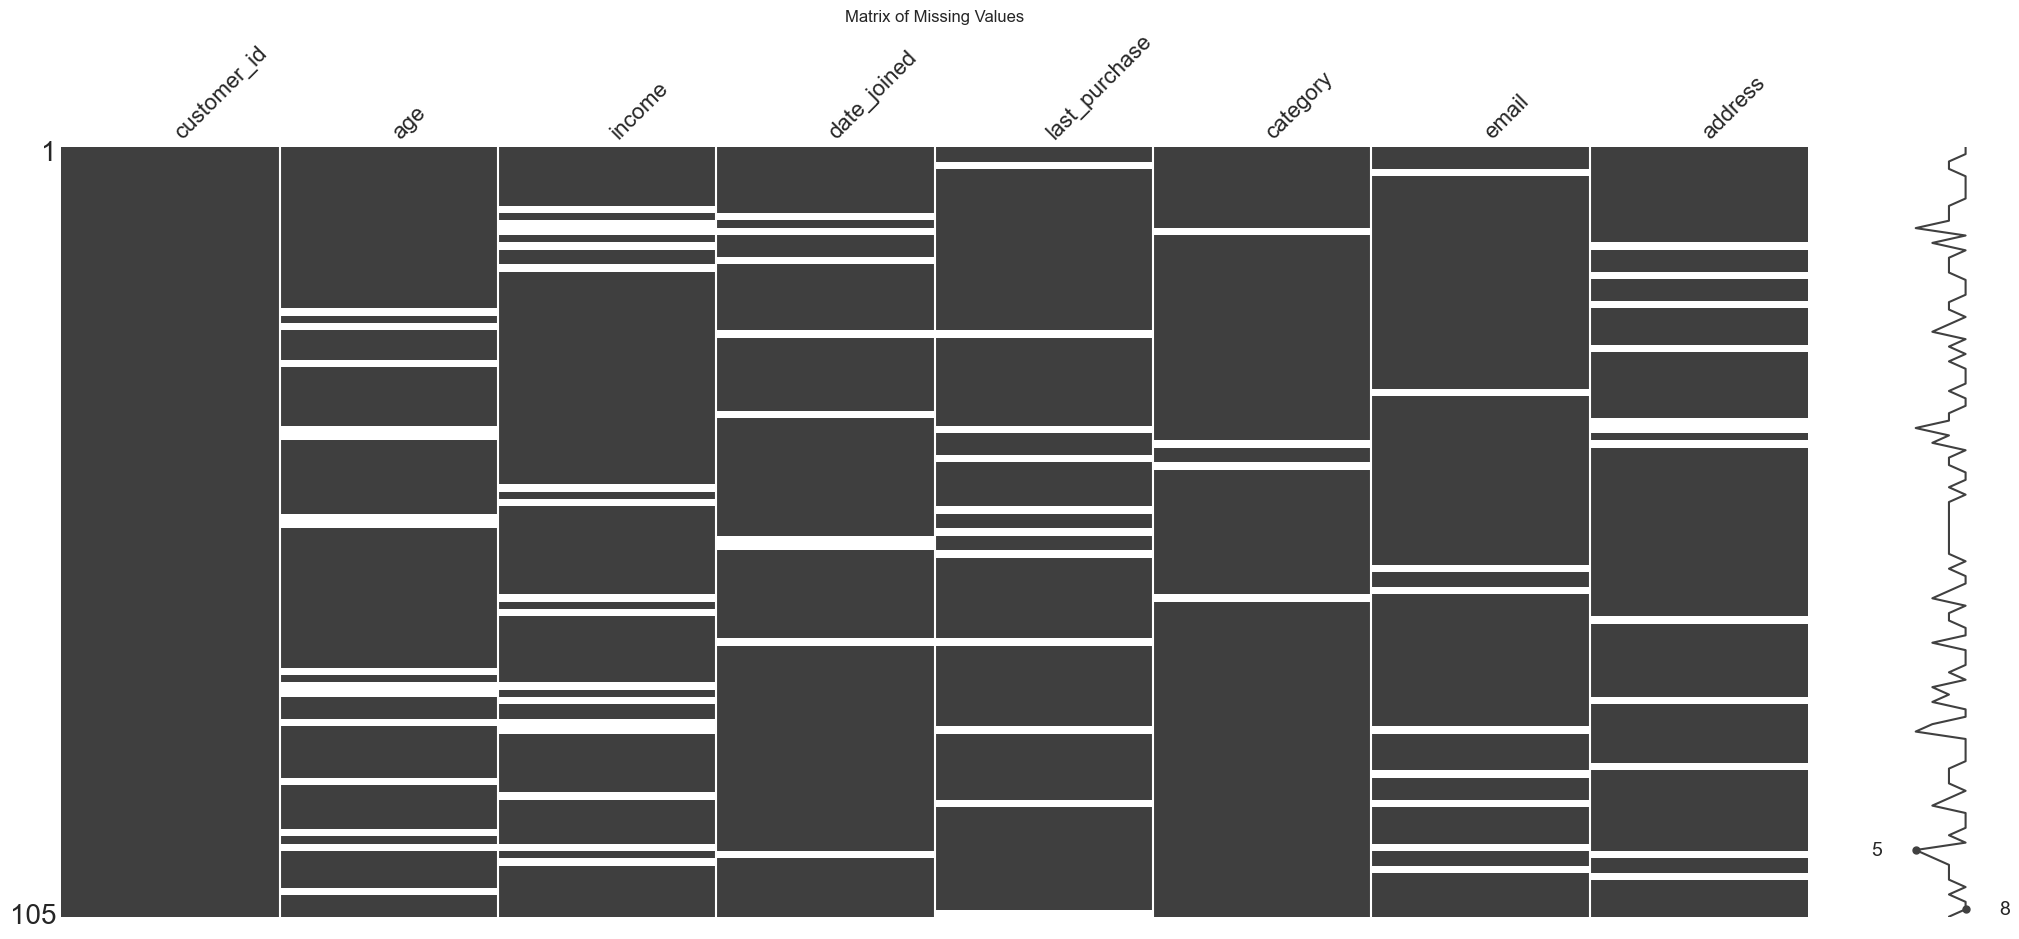

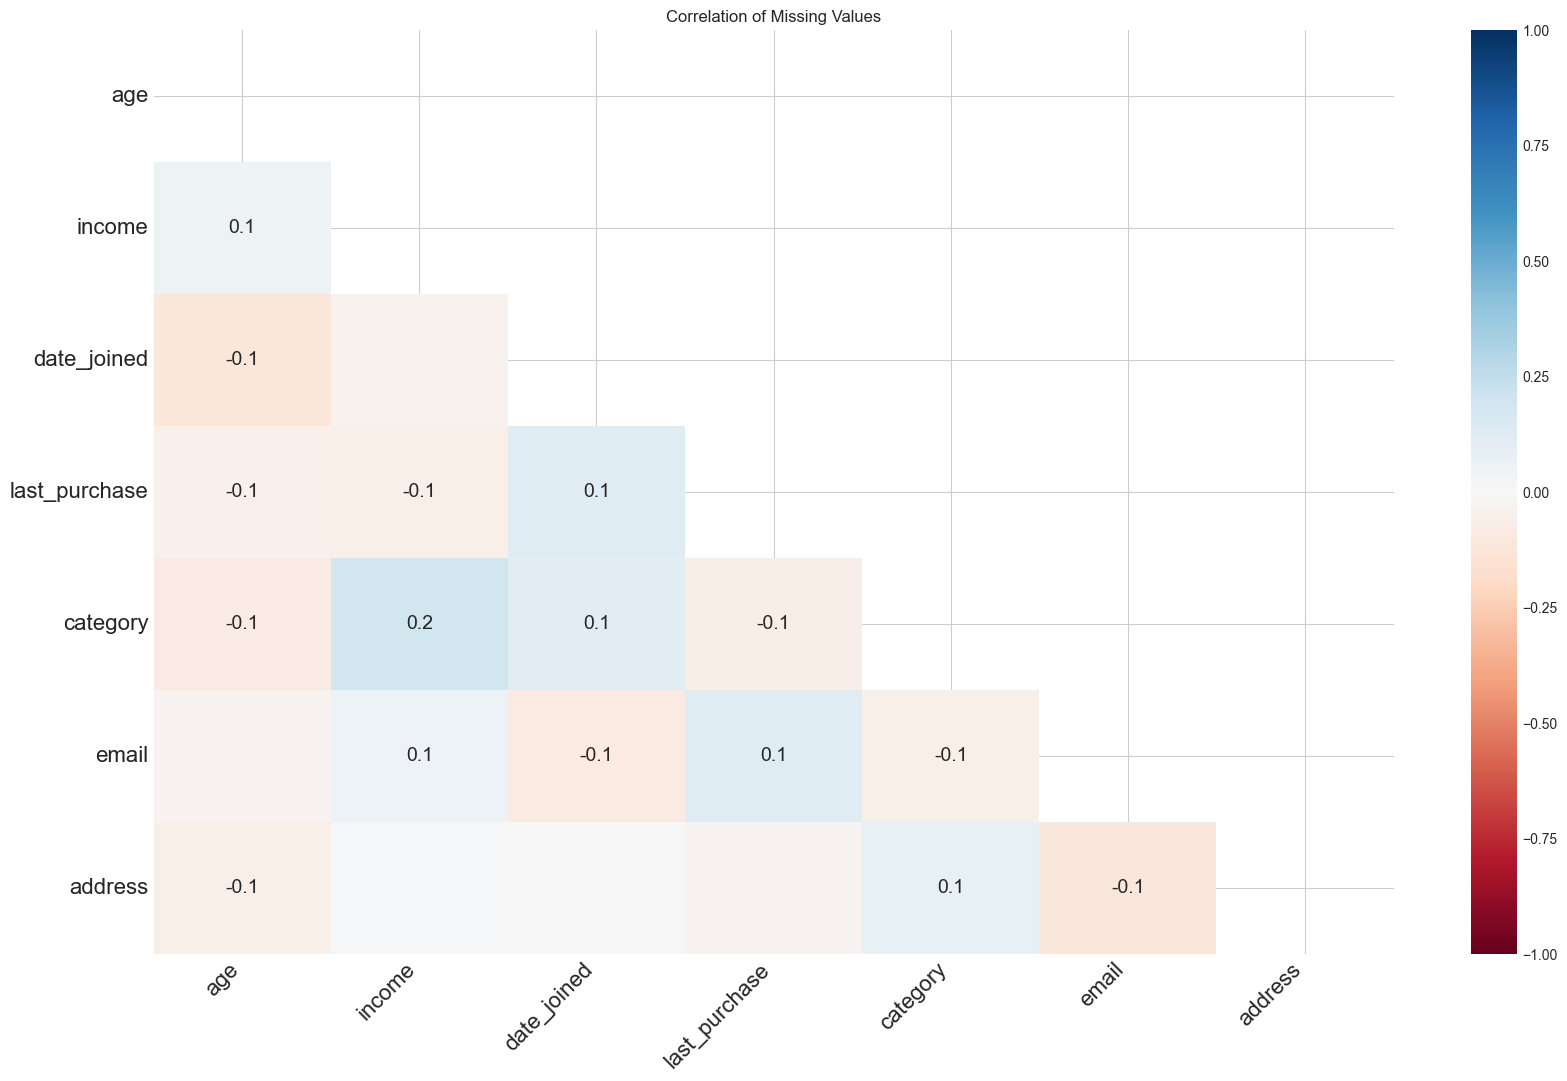

In [6]:
# Install missingno if needed
# !pip install missingno

import missingno as msno

# Matrix visualization of missing values
msno.matrix(messy_data)
plt.title('Matrix of Missing Values')
plt.show()

# Correlation of missing values
msno.heatmap(messy_data)
plt.title('Correlation of Missing Values')
plt.show()

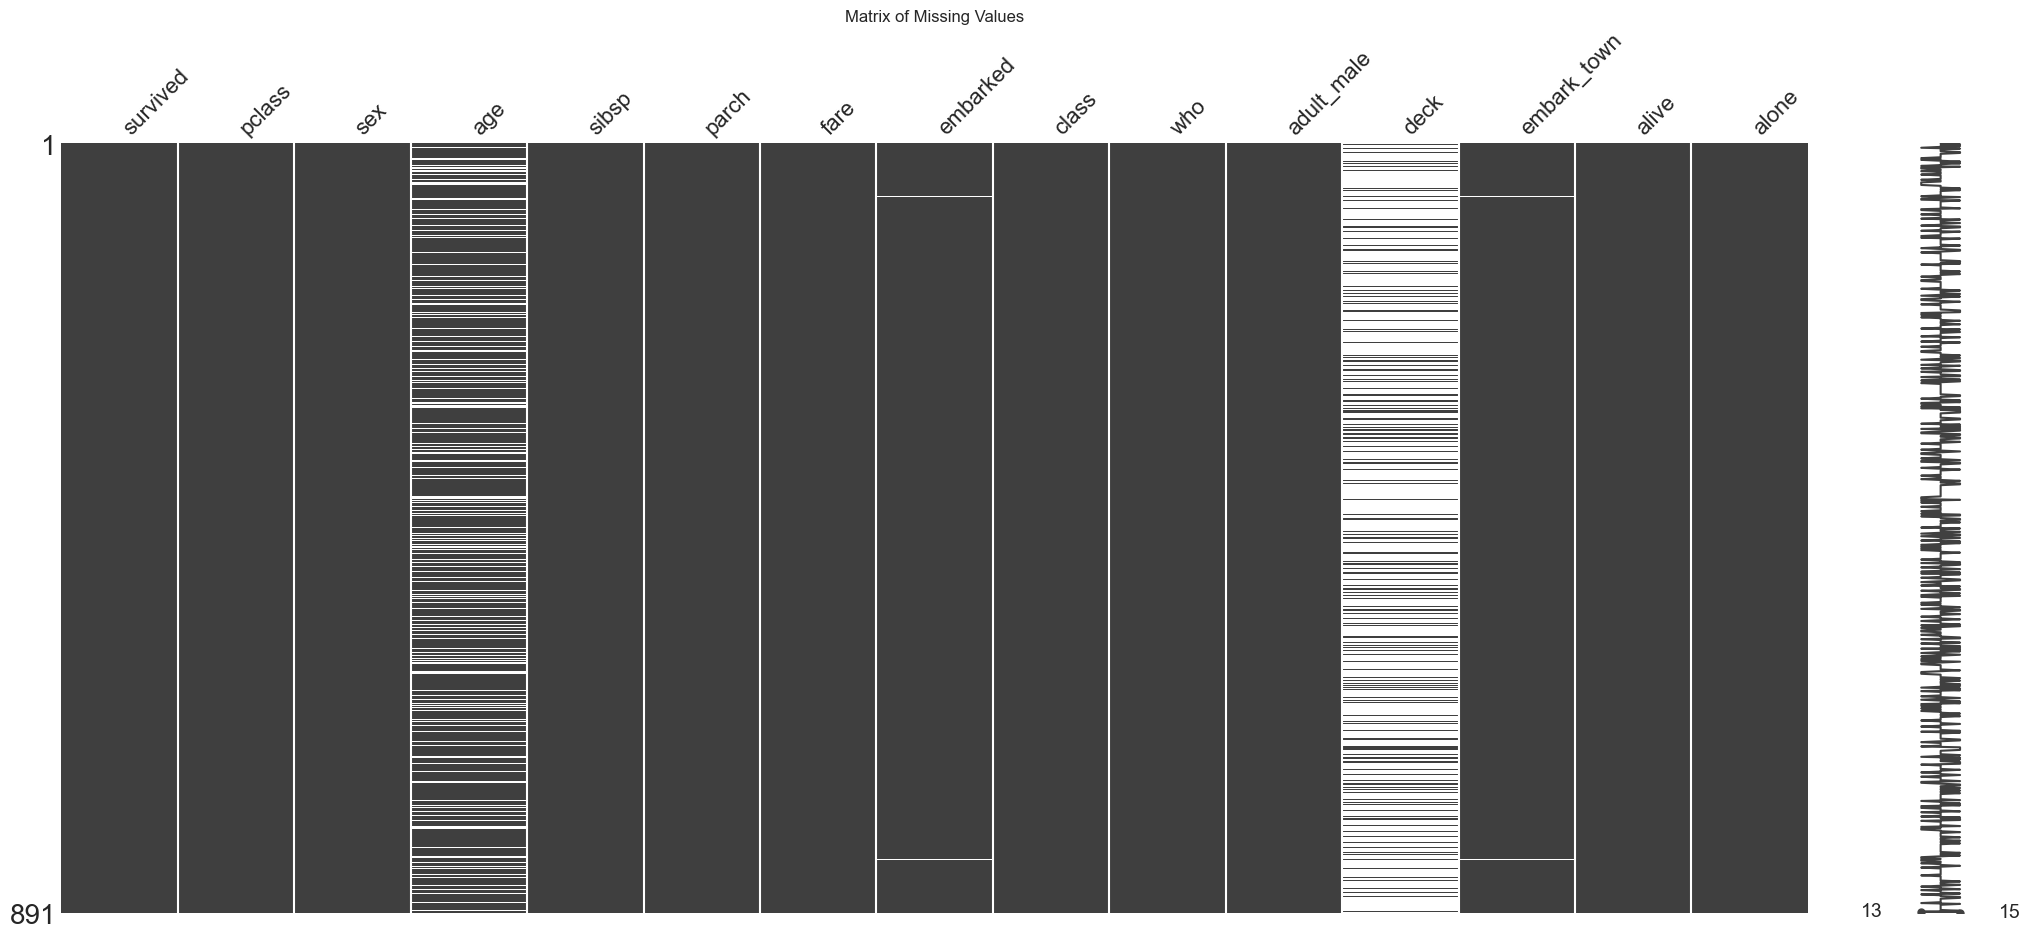

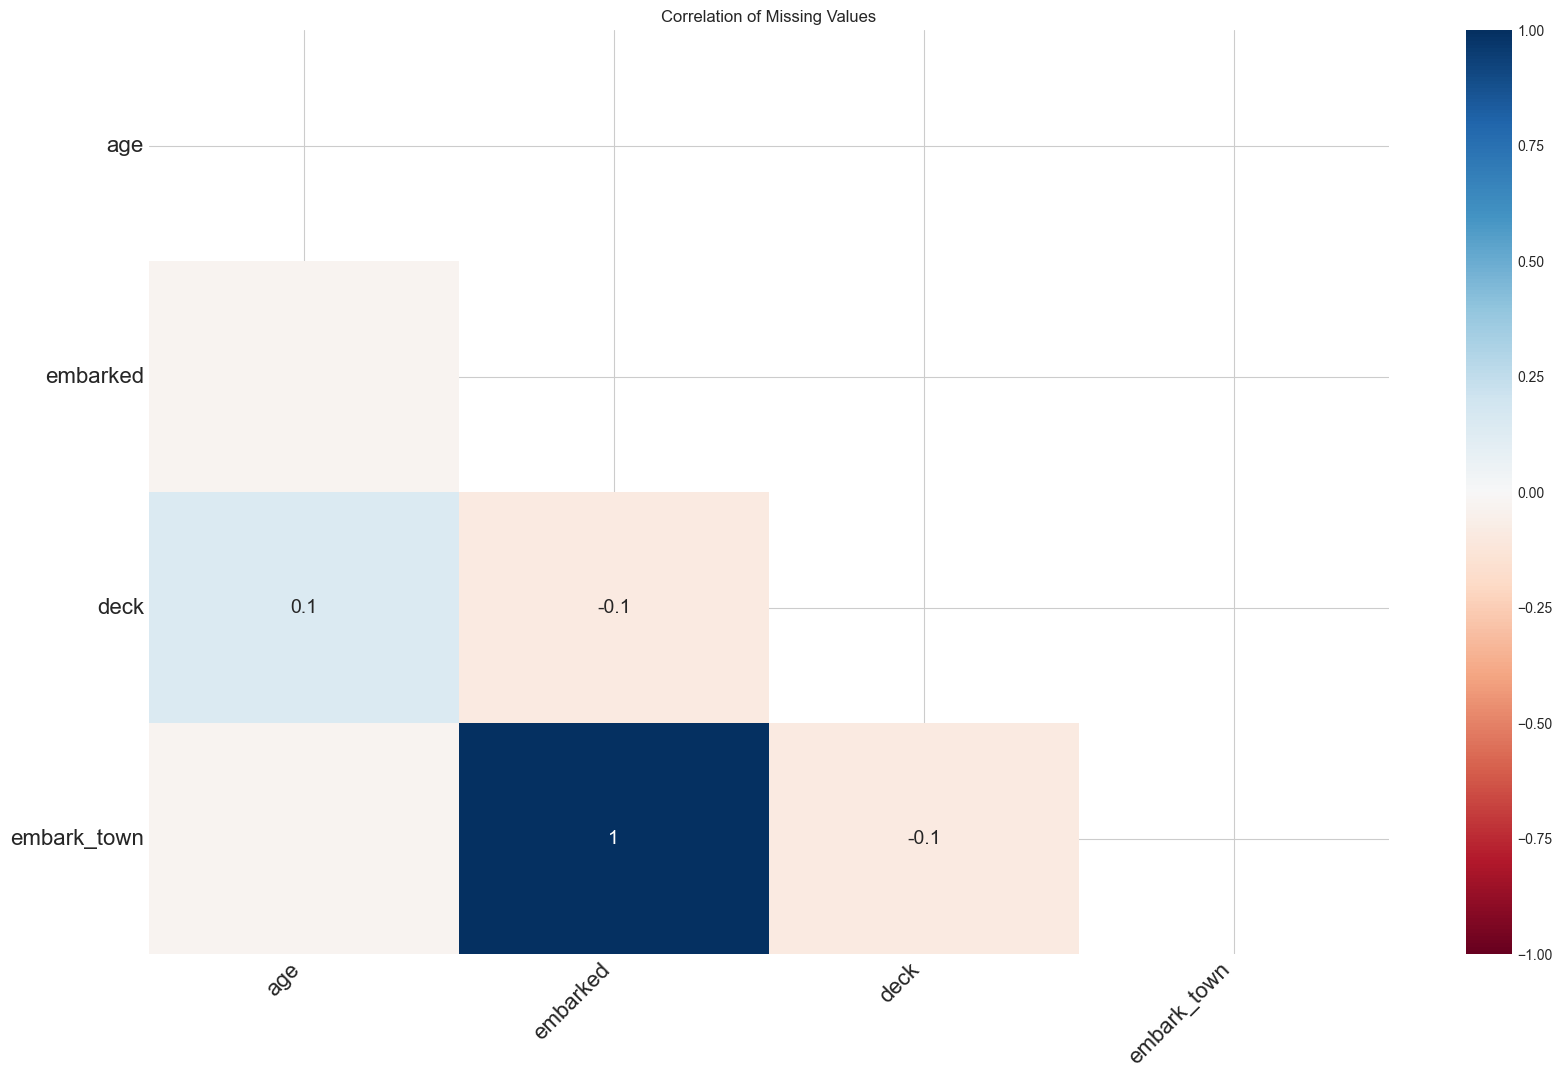

In [7]:
# Install missingno if needed
# !pip install missingno

import missingno as msno

# Matrix visualization of missing values
msno.matrix(titanic)
plt.title('Matrix of Missing Values')
plt.show()

# Correlation of missing values
msno.heatmap(titanic)
plt.title('Correlation of Missing Values')
plt.show()

## Handling Missing Values

There are several strategies for dealing with missing data:

1. Removing rows or columns with missing values
2. Filling missing values with statistical measures (mean, median, mode)
3. Forward/backward fill (for time series data)
4. Using interpolation methods
5. Predictive imputation (using models to predict missing values)

Let's implement some of these strategies:

In [8]:
# # Create a copy of our data to work with
# df_clean = messy_data.copy()

# # 1. Remove rows with too many missing values (more than 50%)
# threshold = len(df_clean.columns) * 0.5
# df_clean = df_clean.dropna(thresh=threshold)
# print(f"Rows after dropping those with >50% missing: {len(df_clean)} (original: {len(messy_data)})")

# # 2. Fill numeric columns with median (more robust to outliers than mean)
# df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())
# df_clean['income'] = df_clean['income'].fillna(df_clean['income'].median())

# # 3. Fill categorical columns with mode
# df_clean['category'] = df_clean['category'].fillna(df_clean['category'].mode()[0])

# # 4. For date columns, use forward fill (assuming the last known date)
# df_clean['date_joined'] = df_clean['date_joined'].fillna(method='ffill')
# df_clean['last_purchase'] = df_clean['last_purchase'].fillna(method='ffill')

# # 5. For text columns, fill with appropriate placeholders
# df_clean['email'] = df_clean['email'].fillna('unknown@example.com')
# df_clean['address'] = df_clean['address'].fillna('No address provided')

# # Check if we have any remaining missing values
# print("\nMissing values after cleaning:")
# print(df_clean.isnull().sum())

In [9]:
# Create a copy of our data to work with
df_clean = messy_data.copy()

# 1. Remove rows with too many missing values (more than 50%)
threshold = len(df_clean.columns) * 0.5
df_clean = df_clean.dropna(thresh=threshold)
print(f"Rows after dropping those with >50% missing: {len(df_clean)} (original: {len(messy_data)})")

# 2. Fill numeric columns with median (more robust to outliers than mean)
df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())
df_clean['income'] = df_clean['income'].fillna(df_clean['income'].median())

# 3. Fill categorical columns with mode
df_clean['category'] = df_clean['category'].fillna(df_clean['category'].mode()[0])

# 4. For date columns, use forward fill (assuming the last known date)
df_clean['date_joined'] = df_clean['date_joined'].ffill()
df_clean['last_purchase'] = df_clean['last_purchase'].ffill()

# 5. For text columns, fill with appropriate placeholders
df_clean['email'] = df_clean['email'].fillna('unknown@example.com')
df_clean['address'] = df_clean['address'].fillna('No address provided')

# Check if we have any remaining missing values
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())

Rows after dropping those with >50% missing: 105 (original: 105)

Missing values after cleaning:
customer_id      0
age              0
income           0
date_joined      0
last_purchase    0
category         0
email            0
address          0
dtype: int64


Let's also demonstrate some more advanced methods for handling missing values:

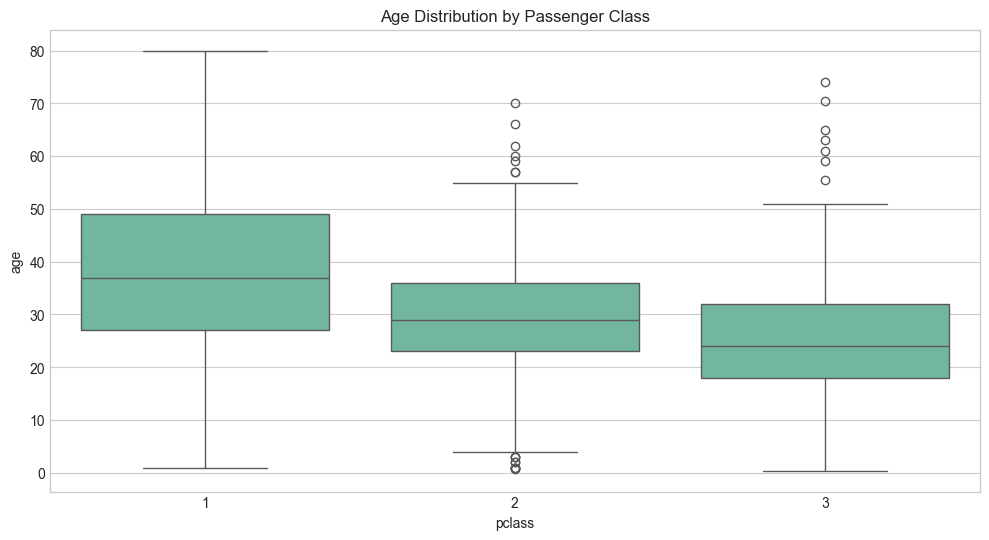

Median age by passenger class and sex:
pclass  sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: age, dtype: float64

Missing values in cleaned Titanic data:
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    2
alive          0
alone          0
dtype: int64


In [10]:
# Working with the Titanic dataset for more practical examples
titanic_clean = titanic.copy()

# Fill 'age' missing values using interpolation based on other features
# First, let's see if there's any correlation between age and other variables
plt.figure(figsize=(12, 6))
sns.boxplot(x='pclass', y='age', data=titanic_clean)
plt.title('Age Distribution by Passenger Class')
plt.show()

# Group median age by passenger class and sex (a common approach)
age_by_group = titanic_clean.groupby(['pclass', 'sex'])['age'].median()
print("Median age by passenger class and sex:")
print(age_by_group)

# Function to fill missing age based on passenger class and sex
def fill_age(row):
    if pd.isnull(row['age']):
        return age_by_group[row['pclass'], row['sex']]
    return row['age']

titanic_clean['age'] = titanic_clean.apply(fill_age, axis=1)

# For the 'embarked' column, use the most frequent value
most_common_embarked = titanic_clean['embarked'].mode()[0]
titanic_clean['embarked'] = titanic_clean['embarked'].fillna(most_common_embarked)

# For 'deck' (cabin first letter), it's mostly missing, so we'll create a 'Unknown' category
# titanic_clean['deck'] = titanic_clean['cabin'].str[0]
# titanic_clean['deck'] = titanic_clean['deck'].fillna('U')  # U for Unknown

# For 'deck' (cabin first letter), it's mostly missing, so we'll create a 'Unknown' category
if 'cabin' in titanic_clean.columns:
    titanic_clean['deck'] = titanic_clean['cabin'].str[0]
    titanic_clean['deck'] = titanic_clean['deck'].fillna('U')  # U for Unknown
else:
    titanic_clean['deck'] = 'U'  # Set all to Unknown if 'cabin' column doesn't exist


print("\nMissing values in cleaned Titanic data:")
print(titanic_clean.isnull().sum())

## Removing Duplicates

Duplicate records can skew your analysis. Let's identify and remove them:

In [11]:
# Check for duplicates in our messy dataset
duplicate_count = messy_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Show some duplicate rows if they exist
if duplicate_count > 0:
    print("\nSample of duplicate rows:")
    duplicates = messy_data[messy_data.duplicated(keep='first')]
    print(duplicates.head())

# Remove duplicates, keeping the first occurrence
df_clean = df_clean.drop_duplicates(keep='first')
print(f"\nRows after removing duplicates: {len(df_clean)}")

# We can also check for duplicates based on specific columns
# For example, duplicate customer IDs
customer_id_dupes = df_clean.duplicated(subset=['customer_id'], keep=False)
print(f"Rows with duplicate customer IDs: {customer_id_dupes.sum()}")

if customer_id_dupes.sum() > 0:
    print("\nSample rows with duplicate customer IDs:")
    print(df_clean[customer_id_dupes].sort_values('customer_id').head())

Number of duplicate rows: 1

Sample of duplicate rows:
     customer_id   age    income date_joined last_purchase category                   email         address
104           53  19.0  57166.31  2020-02-22           NaT        C  customer53@example.com  53 Main Street

Rows after removing duplicates: 105
Rows with duplicate customer IDs: 10

Sample rows with duplicate customer IDs:
     customer_id   age    income date_joined last_purchase category                   email         address
4              5  38.0  64594.45  2020-01-05    2020-02-05        a   customer5@example.com   5 Main Street
102            5  38.0  64594.45  2020-01-05    2020-02-05        A   customer5@example.com   5 Main Street
52            53  19.0  57166.31  2020-02-22    2020-03-23        C  customer53@example.com  53 Main Street
104           53  19.0  57166.31  2020-02-22    2020-04-23        C  customer53@example.com  53 Main Street
100           67  79.0  36790.39  2020-03-07    2020-04-07        A  cust

## Fixing Data Types

Converting columns to appropriate data types is crucial for proper data handling. It improves memory usage and allows for correct operations on the data.

In [12]:
# Check current data types
print("Current data types:")
print(df_clean.dtypes)

# Convert columns to appropriate types
# 1. Convert date columns to datetime if they're not already
df_clean['date_joined'] = pd.to_datetime(df_clean['date_joined'])
df_clean['last_purchase'] = pd.to_datetime(df_clean['last_purchase'])

# 2. Ensure numeric columns are the right type
df_clean['customer_id'] = df_clean['customer_id'].astype('int32')  # smaller int type
df_clean['age'] = df_clean['age'].astype('int16')  # smaller int type
# Income should be float for precision
df_clean['income'] = df_clean['income'].astype('float32')  # smaller float type

# 3. Convert categorical variables to category type for efficiency
df_clean['category'] = df_clean['category'].astype('category')

# Check updated data types
print("\nUpdated data types:")
print(df_clean.dtypes)

# Check memory usage before and after type conversion
original_memory = messy_data.memory_usage(deep=True).sum() / 1024**2  # in MB
optimized_memory = df_clean.memory_usage(deep=True).sum() / 1024**2  # in MB

print(f"\nMemory usage before optimization: {original_memory:.2f} MB")
print(f"Memory usage after optimization: {optimized_memory:.2f} MB")
print(f"Memory savings: {(1 - optimized_memory/original_memory) * 100:.2f}%")

Current data types:
customer_id               int64
age                     float64
income                  float64
date_joined      datetime64[ns]
last_purchase    datetime64[ns]
category                 object
email                    object
address                  object
dtype: object

Updated data types:
customer_id               int32
age                       int16
income                  float32
date_joined      datetime64[ns]
last_purchase    datetime64[ns]
category               category
email                    object
address                  object
dtype: object

Memory usage before optimization: 0.02 MB
Memory usage after optimization: 0.02 MB
Memory savings: 22.24%


## Detecting and Handling Outliers

Outliers can significantly affect statistical analyses and models. Let's identify them using statistical methods and visualizations.

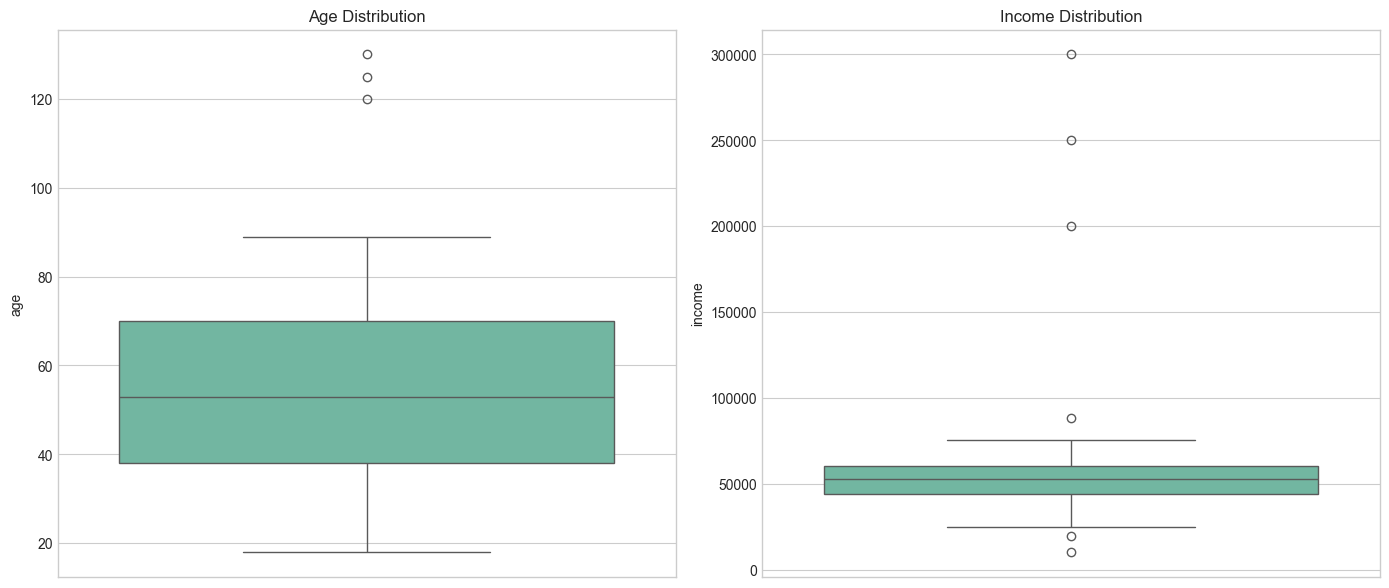

Age outliers detected: 3
Age bounds: [-10.0, 118.0]
    customer_id  age
13           14  120
23           24  130
30           31  125

Income outliers detected: 6
Income bounds: [20294.76, 83978.15]
    customer_id      income
34           35   10172.360
41           42   19665.279
44           45  300000.000
59           60  250000.000
87           88   88087.438


In [13]:
# Visualize distributions to spot outliers
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for age
sns.boxplot(y=df_clean['age'], ax=ax[0])
ax[0].set_title('Age Distribution')

# Boxplot for income
sns.boxplot(y=df_clean['income'], ax=ax[1])
ax[1].set_title('Income Distribution')

plt.tight_layout()
plt.show()

# Let's use the IQR method to detect outliers
def detect_outliers_iqr(df, column, lower_factor=1.5, upper_factor=1.5):
    """Detect outliers using the IQR method"""
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - (lower_factor * iqr)
    upper_bound = q3 + (upper_factor * iqr)
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in age
age_outliers, age_lb, age_ub = detect_outliers_iqr(df_clean, 'age')
print(f"Age outliers detected: {len(age_outliers)}")
print(f"Age bounds: [{age_lb}, {age_ub}]")
print(age_outliers[['customer_id', 'age']].head())

# Detect outliers in income
income_outliers, income_lb, income_ub = detect_outliers_iqr(df_clean, 'income')
print(f"\nIncome outliers detected: {len(income_outliers)}")
print(f"Income bounds: [{income_lb:.2f}, {income_ub:.2f}]")
print(income_outliers[['customer_id', 'income']].head())

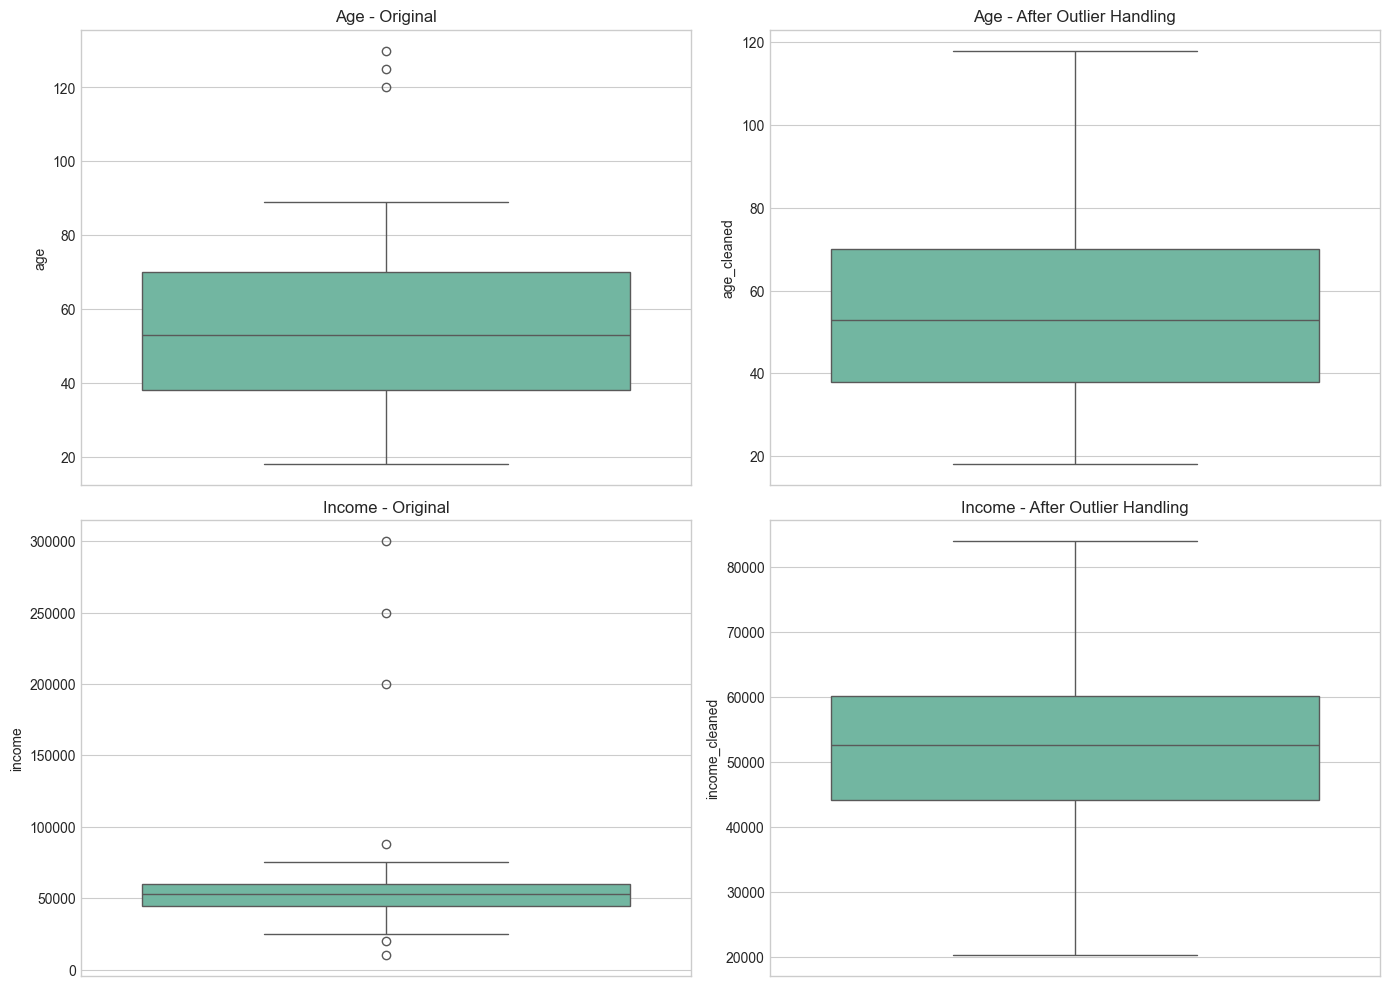

In [14]:
# Handle outliers in age (clipping to a reasonable range)
df_clean['age_cleaned'] = df_clean['age'].clip(lower=age_lb, upper=age_ub)

# For income, use winsorization (similar to clipping but preserves the distribution better)
df_clean['income_cleaned'] = df_clean['income'].clip(lower=income_lb, upper=income_ub)

# Visualize the cleaned distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original age
sns.boxplot(y=df_clean['age'], ax=axes[0,0])
axes[0,0].set_title('Age - Original')

# Cleaned age
sns.boxplot(y=df_clean['age_cleaned'], ax=axes[0,1])
axes[0,1].set_title('Age - After Outlier Handling')

# Original income
sns.boxplot(y=df_clean['income'], ax=axes[1,0])
axes[1,0].set_title('Income - Original')

# Cleaned income
sns.boxplot(y=df_clean['income_cleaned'], ax=axes[1,1])
axes[1,1].set_title('Income - After Outlier Handling')

plt.tight_layout()
plt.show()

## String Cleaning and Standardization

Text data often needs cleaning to remove whitespace, standardize case, handle special characters, and maintain consistent formats.

In [15]:
# Check for inconsistencies in string columns
print("Category values:")
print(df_clean['category'].value_counts())

print("\nSample email values:")
print(df_clean['email'].head(10))

# 1. Clean string values
# Strip whitespace, standardize case for category
df_clean['category'] = df_clean['category'].str.strip().str.upper()

# Clean email addresses
df_clean['email'] = df_clean['email'].str.strip().str.lower()

# Check results after cleaning
print("\nCategory values after cleaning:")
print(df_clean['category'].value_counts())

# 2. Standardize formats (e.g., create a consistent address format)
# Extract and standardize address components
# This is a simplified example - real address parsing would be more complex
df_clean['address_cleaned'] = df_clean['address'].str.replace('Street', 'St.').str.strip()

# Display results
print("\nSample addresses after standardization:")
print(pd.DataFrame({
    'Original': df_clean['address'].head(),
    'Standardized': df_clean['address_cleaned'].head()
}))

Category values:
category
A    30
D    26
C    21
B    16
b     4
d     4
a     3
c     1
Name: count, dtype: int64

Sample email values:
0     customer1@example.com
1     customer2@example.com
2     customer3@example.com
3       unknown@example.com
4     customer5@example.com
5     customer6@example.com
6     customer7@example.com
7     customer8@example.com
8     customer9@example.com
9    customer10@example.com
Name: email, dtype: object

Category values after cleaning:
category
A    33
D    30
C    22
B    20
Name: count, dtype: int64

Sample addresses after standardization:
        Original Standardized
0  1 Main Street   1 Main St.
1  2 Main Street   2 Main St.
2  3 Main Street   3 Main St.
3  4 Main Street   4 Main St.
4  5 Main Street   5 Main St.


## Applying Data Constraints

Ensuring data validity through domain-specific constraints is essential for reliable analysis.

In [16]:
# Apply domain constraints to make sure data falls within expected ranges
# 1. Age constraints (humans typically live between 0-120 years)
df_clean['age_constrained'] = df_clean['age'].clip(0, 120)

# 2. Income constraints (non-negative values)
df_clean['income_constrained'] = df_clean['income'].clip(lower=0)

# 3. Date constraints (join date must be before last purchase)
invalid_dates = df_clean['date_joined'] > df_clean['last_purchase']
print(f"Records with invalid dates (join date after purchase date): {invalid_dates.sum()}")

# Fix invalid dates by swapping them
if invalid_dates.sum() > 0:
    temp = df_clean.loc[invalid_dates, 'date_joined'].copy()
    df_clean.loc[invalid_dates, 'date_joined'] = df_clean.loc[invalid_dates, 'last_purchase']
    df_clean.loc[invalid_dates, 'last_purchase'] = temp
    
    # Verify fix
    invalid_dates_after = df_clean['date_joined'] > df_clean['last_purchase']
    print(f"Records with invalid dates after fixing: {invalid_dates_after.sum()}")

# 4. Email format validation using a simple regex pattern
import re
email_pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'

df_clean['valid_email'] = df_clean['email'].str.match(email_pattern)
invalid_emails = ~df_clean['valid_email']
print(f"Records with invalid email format: {invalid_emails.sum()}")

if invalid_emails.sum() > 0:
    print("Sample invalid emails:")
    print(df_clean.loc[invalid_emails, 'email'].head())

Records with invalid dates (join date after purchase date): 0
Records with invalid email format: 0


## Data Cleaning Pipeline

Now, let's combine all of these cleaning techniques into a reusable data cleaning pipeline function:

In [17]:
# def clean_customer_data(df, handle_outliers=True, standardize_strings=True, apply_constraints=True):
#     """
#     A comprehensive data cleaning pipeline for customer datasets
    
#     Parameters:
#     -----------
#     df : pandas DataFrame
#         The input DataFrame to clean
#     handle_outliers : bool
#         Whether to handle outliers in numeric columns
#     standardize_strings : bool
#         Whether to standardize string values
#     apply_constraints : bool
#         Whether to apply domain constraints
        
#     Returns:
#     --------
#     pandas DataFrame
#         The cleaned DataFrame
#     """
#     # Create a copy to avoid modifying the original
#     clean_df = df.copy()
    
#     # 1. Handle missing values
#     # Drop rows with too many missing values (>50%)
#     threshold = len(clean_df.columns) * 0.5
#     clean_df = clean_df.dropna(thresh=threshold)
    
#     # Fill numeric columns with median
#     for col in ['age', 'income']:
#         if col in clean_df.columns:
#             clean_df[col] = clean_df[col].fillna(clean_df[col].median())
    
#     # Fill categorical columns with mode
#     for col in ['category']:
#         if col in clean_df.columns:
#             clean_df[col] = clean_df[col].fillna(clean_df[col].mode()[0])
    
#     # For date columns, use forward fill
#     for col in ['date_joined', 'last_purchase']:
#         if col in clean_df.columns:
#             clean_df[col] = clean_df[col].fillna(method='ffill')
    
#     # For text columns, fill with appropriate placeholders
#     if 'email' in clean_df.columns:
#         clean_df['email'] = clean_df['email'].fillna('unknown@example.com')
#     if 'address' in clean_df.columns:
#         clean_df['address'] = clean_df['address'].fillna('No address provided')
    
#     # 2. Remove duplicates
#     clean_df = clean_df.drop_duplicates()
    
#     # 3. Fix data types
#     type_conversions = {
#         'customer_id': 'int32',
#         'age': 'int16',
#         'income': 'float32',
#         'category': 'category',
#     }
    
#     for col, dtype in type_conversions.items():
#         if col in clean_df.columns:
#             clean_df[col] = clean_df[col].astype(dtype)
    
#     # Convert date columns to datetime
#     for col in ['date_joined', 'last_purchase']:
#         if col in clean_df.columns:
#             clean_df[col] = pd.to_datetime(clean_df[col])
    
#     # 4. Handle outliers if requested
#     if handle_outliers:
#         # Handle age outliers
#         if 'age' in clean_df.columns:
#             q1 = clean_df['age'].quantile(0.25)
#             q3 = clean_df['age'].quantile(0.75)
#             iqr = q3 - q1
#             lower_bound = max(0, q1 - (1.5 * iqr))  # Age can't be negative
#             upper_bound = q3 + (1.5 * iqr)
#             clean_df['age'] = clean_df['age'].clip(lower=lower_bound, upper=upper_bound)
        
#         # Handle income outliers
#         if 'income' in clean_df.columns:
#             q1 = clean_df['income'].quantile(0.25)
#             q3 = clean_df['income'].quantile(0.75)
#             iqr = q3 - q1
#             lower_bound = max(0, q1 - (1.5 * iqr))  # Income can't be negative
#             upper_bound = q3 + (1.5 * iqr)
#             clean_df['income'] = clean_df['income'].clip(lower=lower_bound, upper=upper_bound)
    
#     # 5. Standardize strings if requested
#     if standardize_strings:
#         # Standardize category values
#         if 'category' in clean_df.columns:
#             clean_df['category'] = clean_df['category'].str.strip().str.upper()
        
#         # Clean email addresses
#         if 'email' in clean_df.columns:
#             clean_df['email'] = clean_df['email'].str.strip().str.lower()
        
#         # Standardize address format
#         if 'address' in clean_df.columns:
#             clean_df['address'] = clean_df['address'].str.strip()
    
#     # 6. Apply constraints if requested
#     if apply_constraints:
#         # Age constraints
#         if 'age' in clean_df.columns:
#             clean_df['age'] = clean_df['age'].clip(0, 120)
        
#         # Income constraints
#         if 'income' in clean_df.columns:
#             clean_df['income'] = clean_df['income'].clip(lower=0)
        
#         # Date constraints (join date must be before last purchase)
#         if 'date_joined' in clean_df.columns and 'last_purchase' in clean_df.columns:
#             invalid_dates = clean_df['date_joined'] > clean_df['last_purchase']
#             if invalid_dates.sum() > 0:
#                 # Fix by setting last_purchase to date_joined (assuming it's the correct one)
#                 clean_df.loc[invalid_dates, 'last_purchase'] = clean_df.loc[invalid_dates, 'date_joined']
    
#     return clean_df

In [18]:
def clean_customer_data(df, handle_outliers=True, standardize_strings=True, apply_constraints=True):
    """
    A comprehensive data cleaning pipeline for customer datasets
    """
    # Create a copy to avoid modifying the original
    clean_df = df.copy()
    
    # 1. Handle missing values
    threshold = len(clean_df.columns) * 0.5
    clean_df = clean_df.dropna(thresh=threshold)
    
    # Fill numeric columns with median
    for col in ['age', 'income']:
        if col in clean_df.columns:
            clean_df[col] = clean_df[col].fillna(clean_df[col].median())
    
    # Fill categorical columns with mode
    for col in ['category']:
        if col in clean_df.columns:
            clean_df[col] = clean_df[col].fillna(clean_df[col].mode()[0])
    
    # For date columns, use forward fill
    for col in ['date_joined', 'last_purchase']:
        if col in clean_df.columns:
            clean_df[col] = clean_df[col].ffill()
    
    # For text columns, fill with appropriate placeholders
    if 'email' in clean_df.columns:
        clean_df['email'] = clean_df['email'].fillna('unknown@example.com')
    if 'address' in clean_df.columns:
        clean_df['address'] = clean_df['address'].fillna('No address provided')
    
    # 2. Remove duplicates
    clean_df = clean_df.drop_duplicates()
    
    # 3. Fix data types
    type_conversions = {
        'customer_id': 'int32',
        'age': 'int16',
        'income': 'float32',
        'category': 'category',
    }
    
    for col, dtype in type_conversions.items():
        if col in clean_df.columns:
            clean_df[col] = clean_df[col].astype(dtype)
    
    # Convert date columns to datetime
    for col in ['date_joined', 'last_purchase']:
        if col in clean_df.columns:
            clean_df[col] = pd.to_datetime(clean_df[col])
    
    # 4. Handle outliers if requested
    if handle_outliers:
        if 'age' in clean_df.columns:
            q1 = clean_df['age'].quantile(0.25)
            q3 = clean_df['age'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = max(0, q1 - (1.5 * iqr))
            upper_bound = q3 + (1.5 * iqr)
            clean_df['age'] = clean_df['age'].clip(lower=lower_bound, upper=upper_bound)
        
        if 'income' in clean_df.columns:
            q1 = clean_df['income'].quantile(0.25)
            q3 = clean_df['income'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = max(0, q1 - (1.5 * iqr))
            upper_bound = q3 + (1.5 * iqr)
            clean_df['income'] = clean_df['income'].clip(lower=lower_bound, upper=upper_bound)
    
    # 5. Standardize strings if requested
    if standardize_strings:
        if 'category' in clean_df.columns:
            clean_df['category'] = clean_df['category'].str.strip().str.upper()
        if 'email' in clean_df.columns:
            clean_df['email'] = clean_df['email'].str.strip().str.lower()
        if 'address' in clean_df.columns:
            clean_df['address'] = clean_df['address'].str.strip()
    
    # 6. Apply constraints if requested
    if apply_constraints:
        if 'age' in clean_df.columns:
            clean_df['age'] = clean_df['age'].clip(0, 120)
        if 'income' in clean_df.columns:
            clean_df['income'] = clean_df['income'].clip(lower=0)
        if 'date_joined' in clean_df.columns and 'last_purchase' in clean_df.columns:
            invalid_dates = clean_df['date_joined'] > clean_df['last_purchase']
            if invalid_dates.sum() > 0:
                clean_df.loc[invalid_dates, 'last_purchase'] = clean_df.loc[invalid_dates, 'date_joined']
    
    return clean_df

In [19]:
# Test our pipeline on the original messy data
fully_cleaned_data = clean_customer_data(messy_data)

# Check the results
print("Original data shape:", messy_data.shape)
print("Cleaned data shape:", fully_cleaned_data.shape)

# Check for missing values in the cleaned data
print("\nMissing values in cleaned data:")
print(fully_cleaned_data.isnull().sum())

# Check data types
print("\nData types in cleaned data:")
print(fully_cleaned_data.dtypes)

# Preview the cleaned data
print("\nCleaned data preview:")
fully_cleaned_data.head()

Original data shape: (105, 8)
Cleaned data shape: (105, 8)

Missing values in cleaned data:
customer_id      0
age              0
income           0
date_joined      0
last_purchase    0
category         0
email            0
address          0
dtype: int64

Data types in cleaned data:
customer_id               int32
age                       int16
income                  float64
date_joined      datetime64[ns]
last_purchase    datetime64[ns]
category                 object
email                    object
address                  object
dtype: object

Cleaned data preview:


,customer_id,age,income,date_joined,last_purchase,category,email,address
0,1,69,62521.930,2020-01-01,2020-02-01,B,customer1@example.com,1 Main Street
1,2,32,54448.422,2020-01-02,2020-02-02,C,customer2@example.com,2 Main Street
2,3,89,34432.551,2020-01-03,2020-02-02,D,customer3@example.com,3 Main Street
3,4,78,48862.941,2020-01-04,2020-02-04,A,unknown@example.com,4 Main Street
4,5,38,64594.449,2020-01-05,2020-02-05,A,customer5@example.com,5 Main Street


## Summary

In this notebook, we covered essential data cleaning techniques:

1. **Identifying and handling missing values**:
   - Detection using `isna()`, `isnull()`, and visualization
   - Strategies like dropping, filling, and interpolation

2. **Removing duplicates**:
   - Identifying duplicates with `duplicated()`
   - Removing duplicates using `drop_duplicates()`

3. **Fixing data types**:
   - Converting to appropriate types for efficient memory usage and operations
   - Using category types for categorical data

4. **Detecting and handling outliers**:
   - Using statistical methods (IQR, z-score)
   - Handling using clipping and winsorization

5. **String cleaning and standardization**:
   - Removing whitespace, standardizing case
   - Handling formatting consistency

6. **Applying data constraints**:
   - Ensuring logical relationships between variables
   - Validating formats and ranges

7. **Building a data cleaning pipeline**:
   - Combining all techniques into a reusable function

Clean data is the foundation of good analysis. Investing time in proper data cleaning helps prevent incorrect conclusions and improves the reliability of your models.